# Predicting flood occurrence

In [1]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggfortify' was built under R version 3.3.3"Warning message:
"package 'rpart.plot' was built under R version 3.3.3"Warning message:
"package 'RSQLite' was built under R version 3.3.3"Warning message:
"package 'DBI' was built under R version 3.3.3"Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'e1071' was built under R version 3.3.3"

In [2]:
classify_knn = function(pca.data, obs_data, point, k){
  neighs = get_nn(pca.data, point, k)
  neigh_data = obs_data[neighs,]
  return(names(which.max(table(neigh_data$fld))))
}

In [3]:
get_nn = function(d, point, k){
  point = d[point, ]
  dists = sort(sqrt(rowSums((t(t(d) - point))^2)))
  close_points = names(dists)[2:k]
  return(close_points)
}

In [4]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- paste(base_dir, "Data/", sep="")
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [5]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [6]:
df = dbReadTable(con, 'for_model')
df = subset(df, rain_daily_sum>0.1) # only look at days that have over 0.1 in of rainfall
df = df[!is.na(df$gw_daily_avg),] # remove null gw values
short_names = c('rd', 'rhr', 'rhmxtime', 'r15', 'r15mxtime', 'r3d', 'gw', 'td', 'tr15mx', 'trhrmx', 'wdd', 'wvd',  'wvh', 'nfld', 'fld', 'evnme', 'evdte')
colnames(df) = short_names

In [7]:
in_col_names = c('rd', 'rhr', 'r15', 'r3d', 'gw', 'td', 'wvd', 'tr15mx', 'trhrmx')
out_col_name = 'fld'
data = df[, c(in_col_names, out_col_name)]
data$fld = df$fld>0

### PCA transform

,rd,rhr,r15,r3d,gw,td,wvd,tr15mx,trhrmx,fld
20,0.8325000,0.64,0.28,1.070000e+00,4.438215,0.5746250,12.273861,-0.620,-0.620,TRUE
17,1.3100000,1.09,0.33,1.310000e+00,4.156397,-0.5251667,7.875028,-1.175,-1.175,TRUE
18,0.9550000,0.70,0.36,-2.081668e-15,4.987574,0.5352500,15.667056,2.093,1.699,TRUE
15,0.5750000,0.15,0.08,5.000000e-03,2.788770,1.7037639,9.681333,0.466,0.466,TRUE
13,0.5000000,0.62,0.47,6.466667e-01,2.344772,0.1430833,4.353889,-1.178,-1.178,TRUE
6,0.8433333,1.13,0.54,8.433333e-01,1.637858,0.3175625,7.114194,0.282,0.282,TRUE
2268,0.5325000,0.37,0.13,1.262500e+00,4.353069,0.4907917,9.146271,-0.348,-0.348,FALSE
7,1.4800000,1.28,0.63,1.480000e+00,1.339840,-0.4952083,9.391160,0.876,-0.007,TRUE
2148,0.7100000,0.16,0.05,7.100000e-01,4.188372,0.9031667,10.890118,0.502,0.007,FALSE
2342,0.3825000,0.46,0.27,3.825000e-01,3.486622,0.1025833,9.356847,-0.220,-0.220,FALSE


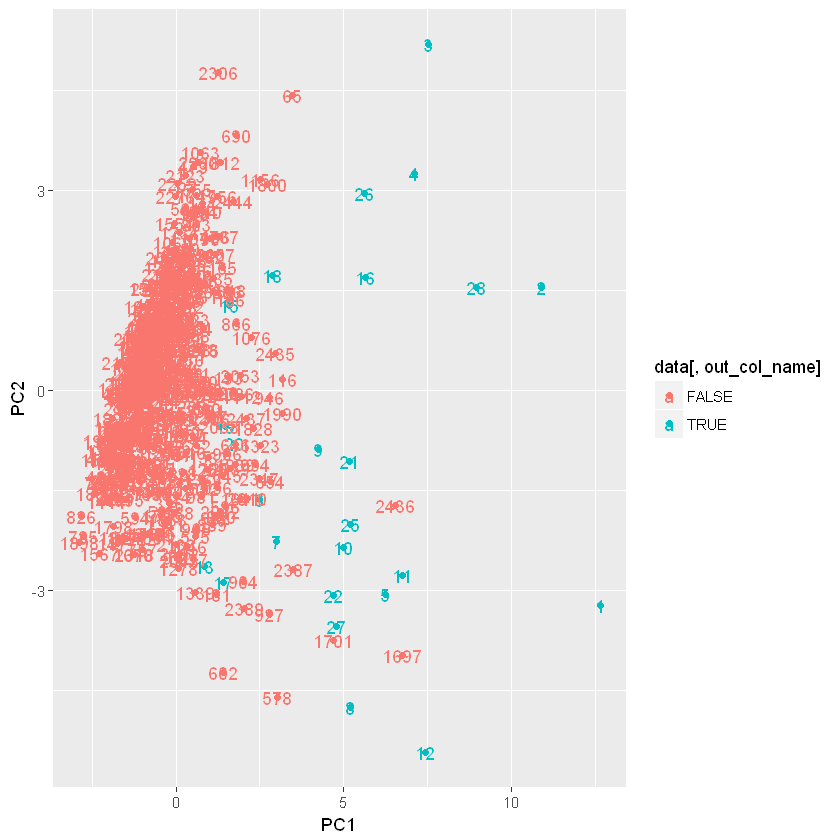

In [8]:
pca_data = data.frame(scale(data))
pca = prcomp(pca_data)
pca$x = -pca$x
pca$rotation=-pca$rotation
p = ggplot(pca$x[,c(1,2)], aes(x=PC1, y=PC2, colour=data[, out_col_name], label=rownames(pca$x)))
p + geom_point() +geom_text()
point = "19"
neighs = get_nn(pca$x, point, k=11)
data[neighs,]

### Partition data into training/testing sets

In [9]:
data$fld = factor(data$fld)
prt = createDataPartition(data$fld, p=0.7)
train_ind = prt$Resample1

### KNN

In [10]:
kfit = knn(pca$x[train_ind, ], pca$x[-train_ind, ], data[train_ind, 'fld'], k=5)
table(data[-train_ind, 'fld'], kfit)

       kfit
        FALSE TRUE
  FALSE   142    0
  TRUE      1    6

### SVM

In [11]:
svm_fit = svm(x=pca$x[train_ind,], y=data[train_ind, 'fld'])
svm_pred = predict(svm_fit, pca$x[-train_ind,])
table(data[-train_ind, out_col_name], svm_pred)

       svm_pred
        FALSE TRUE
  FALSE   142    0
  TRUE      1    6

### Decision Trees

In [12]:
fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))

fit = rpart(fmla, method='class', data=data[train_ind, ], minsplit=2)
printcp(fit)


Classification tree:
rpart(formula = fmla, data = data[train_ind, ], method = "class", 
    minsplit = 2)

Variables actually used in tree construction:
[1] gw  r3d rd  rhr td 

Root node error: 18/352 = 0.051136

n= 352 

        CP nsplit rel error  xerror    xstd
1 0.444444      0   1.00000 1.00000 0.22960
2 0.166667      1   0.55556 0.77778 0.20369
3 0.083333      2   0.38889 0.61111 0.18136
4 0.055556      4   0.22222 0.61111 0.18136
5 0.027778      5   0.16667 0.72222 0.19657
6 0.010000     11   0.00000 0.77778 0.20369


png 
  2

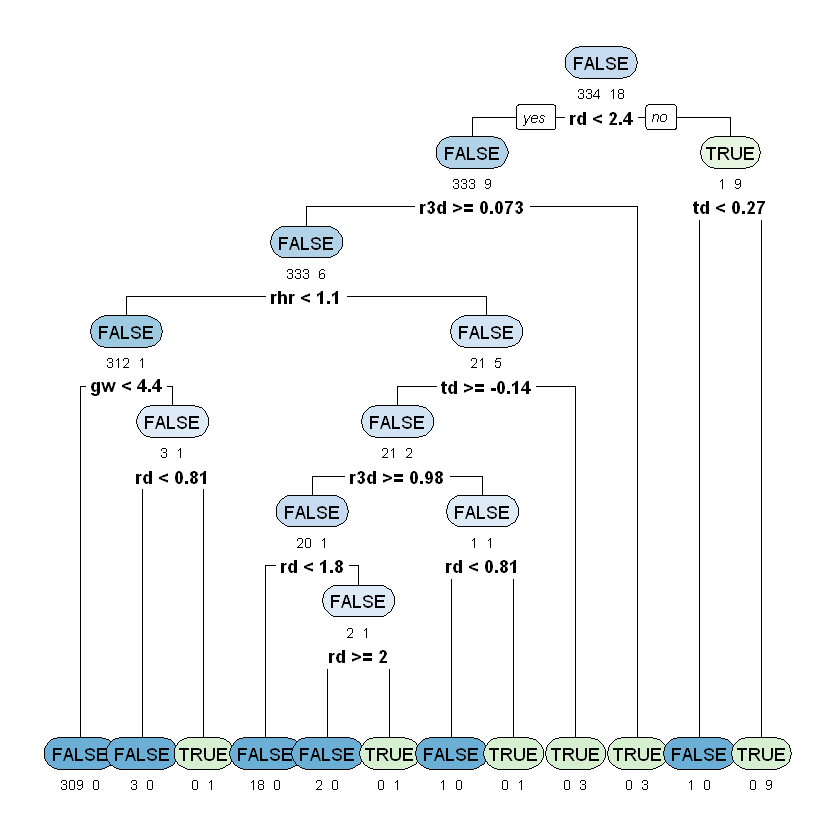

In [13]:
tiff(paste(fig_dir, "Plot2.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

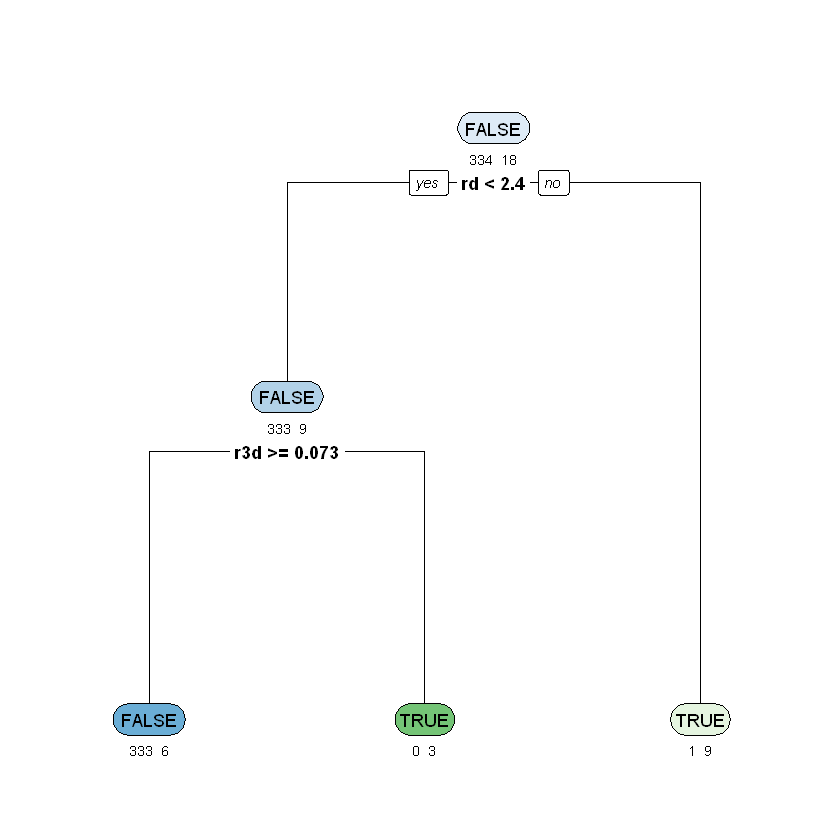

In [14]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.9, extra=1, varlen = 6)

#### Decision Tree training results

In [15]:
pred = predict(pfit, data[train_ind, in_col_names], type = 'class')
true_fld = data[train_ind, 'fld']
table(data[train_ind, out_col_name], pred)

       pred
        FALSE TRUE
  FALSE   333    1
  TRUE      6   12

#### Decision Tree testing results

In [16]:
pred = predict(pfit, data[-train_ind, in_col_names], type = 'class')
true_fld = data[train_ind, 'fld']
print('DT test')
table(data[-train_ind, out_col_name], pred)

[1] "DT test"


       pred
        FALSE TRUE
  FALSE   140    2
  TRUE      4    3

### Random Forests

In [17]:
forest = randomForest(fmla, data = data[train_ind, ], importance = TRUE, type="classification", nodesize=2)

pred = predict(forest, data[train_ind, in_col_names])
true_fld = data[train_ind, 'fld']
print('RF train')
print(sum(pred == true_fld)/length(true_fld))
table(data[train_ind, out_col_name], pred)

[1] "RF train"
[1] 0.9971591


       pred
        FALSE TRUE
  FALSE   334    0
  TRUE      1   17

In [18]:
pred = predict(forest, data[-train_ind, in_col_names])
true_fld = data[-train_ind, 'fld']
print('RF test')
table(data[-train_ind, out_col_name], pred)
forest$importance

[1] "RF test"


       pred
        FALSE TRUE
  FALSE   141    1
  TRUE      4    3

,FALSE,TRUE,MeanDecreaseAccuracy,MeanDecreaseGini
rd,0.0171651162,0.198164935,0.0263195115,9.815786
rhr,0.0127036534,0.073530447,0.0156931730,4.929426
r15,0.0031995812,0.021934343,0.0042876629,2.323800
r3d,0.0120676710,0.040143218,0.0134475039,5.888911
gw,0.0004244413,0.007231674,0.0007456628,2.486018
td,0.0032007452,0.011673016,0.0036477977,2.943354
wvd,0.0010102942,0.004723160,0.0012449054,1.882223
tr15mx,0.0002329530,0.003870635,0.0003888176,1.347267
trhrmx,0.0006047182,0.006148557,0.0008099082,1.338934
